In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.5 MB/s eta 0:00:00


Importing the Libraries

In [ ]:
import pandas as pd
import csv
import re
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import roc_curve

# **DATA PREPROCESSING**



*   Formatting the dataset

In [ ]:
def extract(text):
    # Split the text on the last comma to separate the boolean value
    parts = text.rsplit(',', 1)
    # Extract the string part and trim any extra whitespace
    if len(parts) == 2:
        es = parts[0].strip()
        bv = parts[1].strip().lower() == 'true'
    else: # If there's no comma, handle it by returning the entire text and a default false value
        es = text.strip()
        bv = False

    return es, bv

def process_file(filepath, output_filepath):
    results = [] # List to store the results as tuples (extracted_string, boolean_value)
    s = ""

    with open(filepath, 'r') as file:
        ls = file.readlines()

    # Process each line in the file
    for i, l in enumerate(ls):
        l = l.strip()
        if l:
            s += l + " "
        if (i + 1 == len(ls) or not ls[i + 1].strip()) and s:
            es, bv = extract(s.strip())
            results.append((es, bv))
            s = ""
    with open(output_filepath, 'w') as outfile:
        for result in results:
            outfile.write(f"{result[0]}, {result[1]}\n")

input_file_path = 'llama2_sarcasm_training_data.txt'
output_file_path = 'output_file.txt'
process_file(input_file_path, output_file_path)





*   Handling URLs, Hashtags and Mentions



In [ ]:

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    return text.strip()

def process_csv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        r = csv.reader(file)
        h = next(r)
        df = list(r)
# Clean text in the CSV data
    cleaned_data = [(clean_text(row[0]), row[1]) for row in df]
 # Write cleaned data to a new CSV file
    with open(output_file, 'w', newline='', encoding='utf-8') as file:
        w = csv.writer(file)
        w.writerow(h)
        for row in cleaned_data:
            w.writerow(row)

    print("Cleaned data has been written to", output_file)

process_csv('output.csv', 'cleaned_output.csv')


Cleaned data has been written to cleaned_output.csv




*   Replacing Emojis to a descriptive word



In [ ]:

def replace_emojis_with_descriptions(text):
    def replace(match):
        emoji_desc = match.group(0)
        try:
            return emoji.demojize(emoji_desc)
        except KeyError:
            return ''  # If emoji not found, replace with an empty string

    emojis = re.compile("["
                       u"\U0001F600-\U0001F64F"
                       u"\U0001F300-\U0001F5FF"
                       u"\U0001F680-\U0001F6FF"
                       u"\U0001F700-\U0001F77F"
                       u"\U0001F780-\U0001F7FF"
                       u"\U0001F800-\U0001F8FF"
                       u"\U0001F900-\U0001F9FF"
                       u"\U0001FA00-\U0001FA6F"
                       u"\U0001FA70-\U0001FAFF"
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)
    return emojis.sub(replace, text)

def process_file(input_file_path, output_file_path):
    with open(input_file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    cleaned_lines = [replace_emojis_with_descriptions(line) for line in lines]

    with open(output_file_path, 'w', encoding='utf-8') as file:
        file.writelines(cleaned_lines)

input_path = 'Tweet.txt'
output_path = 'cleaned.txt'
process_file(input_path, output_path)



*   Handling Abbreviations



In [ ]:
def expand_contractions(text):
    # Define common contractions and their expansions
    contractions_dict = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "could've": "could have",
        "couldn't": "could not",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'll": "he will",
        "he's": "he is",
        "how'd": "how did",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'll": "I will",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it would",
        "it'll": "it will",
        "it's": "it is",
        "let's": "let us",
        "mustn't": "must not",
        "shan't": "shall not",
        "she'd": "she would",
        "she'll": "she will",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "that's": "that is",
        "there's": "there is",
        "they'd": "they would",
        "they'll": "they will",
        "they're": "they are",
        "they've": "they have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'll": "we will",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "where'd": "where did",
        "where's": "where is",
        "who'll": "who will",
        "who's": "who is",
        "won't": "will not",
        "would've": "would have",
        "wouldn't": "would not",
        "you'd": "you would",
        "you'll": "you will",
        "you're": "you are",
        "you've": "you have"
    }

    # Regular expression pattern for finding contractions
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    def expand_match(contraction):
        match = contraction.group(0)
        expanded_contraction = contractions_dict.get(match) if contractions_dict.get(match) else contractions_dict.get(match.lower())
        return expanded_contraction

    # Replace contractions with their expansions
    expanded_text = contractions_re.sub(expand_match, text)
    return expanded_text

# Open final.txt for reading
with open('cleaned.txt', 'r') as infile:
    # Read lines from the file
    lines = infile.readlines()

# Apply expand_contractions() function to each line
expanded_lines = [expand_contractions(line) for line in lines]

# Write the expanded content to expanded_final.txt
with open('final.txt', 'w') as outfile:
    # Write each expanded line to the output file
    for line in expanded_lines:
        outfile.write(line)



*   Removing Special Characters

In [ ]:

# Define a function to remove special characters
def remove_special_characters(text):
    # Remove special characters except for ",", ".", "!", and newline characters
    cleaned_text = re.sub(r'[^\w\s,.!\n]', '', text)
    return cleaned_text

# Open final.txt for reading
with open('final.txt', 'r') as infile:
    # Read lines from the file
    lines = infile.readlines()

# Apply remove_special_characters() function to each line
cleaned_lines = [remove_special_characters(line) for line in lines]

# Write the cleaned content to final_cleaned.txt
with open('final_cleaned.txt', 'w') as outfile:
    # Write each cleaned line to the output file
    for line in cleaned_lines:
        outfile.write(line)


# **Tokenization**

In [ ]:

df = pd.read_csv('merged_file.csv', index_col=False)

df.head()

,Tweet,Sarcasm
0,Fantastic service yet again from EE. 1st you u...,yes
1,Not sure if that was or. I will take it! face_...,yes
2,Barely 9 am and already shaking with rage.,yes
3,I guess that proves it then. Black folks have ...,yes
4,Does this tweet need a tag,yes




*   Word Tokenization




In [ ]:

# Initialize the TweetTokenizer
tokenizer = TweetTokenizer()

def tokenize_text(Tweet):
    return tokenizer.tokenize(Tweet)

df = pd.read_csv('merged_file.csv')
df['tokens'] = df['Tweet'].apply(tokenize_text)

print(df.head(15))
df.to_csv('t_dataset.csv', index=False)

                                                Tweet Sarcasm  \
0   Fantastic service yet again from EE. 1st you u...     yes   
1   Not sure if that was or. I will take it! face_...     yes   
2          Barely 9 am and already shaking with rage.     yes   
3   I guess that proves it then. Black folks have ...     yes   
4                          Does this tweet need a tag     yes   
5   both. Wont be using you again. Made a formal c...     yes   
6                Fuuuuuuuuck this shit screams thug!!     yes   
7   66 UEs from Staniel and he wins in straights. ...     yes   
8              totally surprising to every husker fan     yes   
9                     Haha got to love the enthusiasm     yes   
10  a southern pride advocate but of course it has...     yes   
11  So nice not hearing any rumors that the  are n...     yes   
12  We should divide illegals into two lines one f...     yes   
13      does not even look like that great of a view.     yes   
14  Mondays are always dr

# **Encoding**


*   TF-IDF(Term Frequency-Inverse Document Frequency)


In [ ]:
#tfidf
tweets = df['Tweet']
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(tweets)
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
final_df = pd.concat([df.drop('Tweet', axis=1), tfidf_df], axis=1)
final_df.to_csv("tfidf_encoded_tweets.csv", index=False)

# **Handling Imbalance in our Dataset**



*   Finding if our dataset has imbalance



In [ ]:
y = df['Sarcasm']
y.value_counts()

Sarcasm
yes    1687
no     1294
Name: count, dtype: int64

<Axes: ylabel='count'>

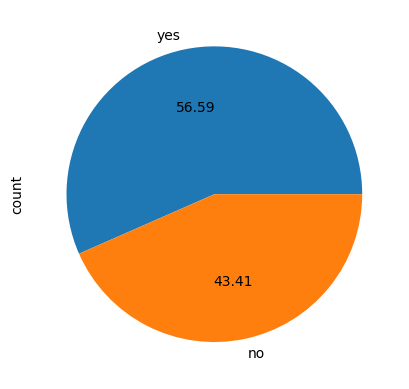

In [ ]:
y.value_counts().plot.pie(autopct='%.2f')



*   Random Oversampling



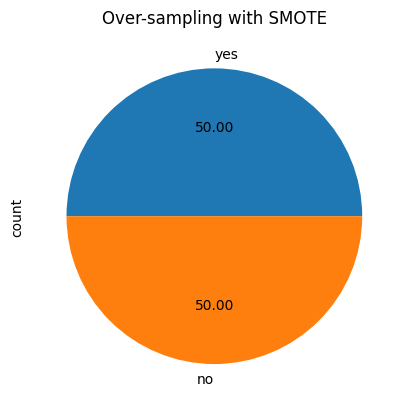

Sarcasm
yes    1687
no     1687
Name: count, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
# Convert text data to numerical data using TF-IDF
tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['Tweet'])
y = df['Sarcasm']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)
ax = y_resampled.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling with SMOTE")
plt.show()
y_resampled.value_counts()

# **ML Model**

Importing the Dataset

In [ ]:
df = pd.read_csv('t_dataset.csv', index_col=False)

Function for Model Evaluation

In [ ]:
def evaluate_model(y_test, y_pred, y_pred_prob):
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
df['Sarcasm'] = df['Sarcasm'].map({'yes': 1, 'no': 0})

Splitting the dataset into Train and Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Sarcasm'], test_size=0.2, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

**Logistic Regression**

In [ ]:
# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)
y_train = y_train.map({'yes': 1, 'no': 0})

y_pred = model.predict(X_test_tfidf)
y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1]

Accuracy: 77.89%
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.59      0.69       250
           1       0.76      0.91      0.83       347

    accuracy                           0.78       597
   macro avg       0.79      0.75      0.76       597
weighted avg       0.79      0.78      0.77       597



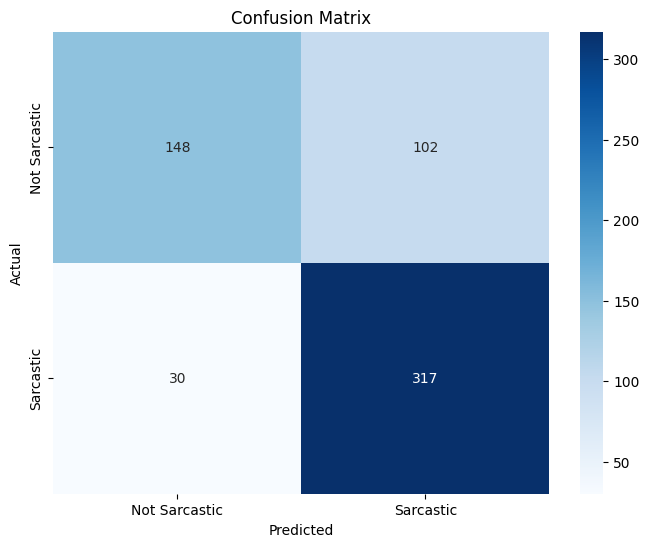

In [ ]:
evaluate_model(y_test, y_pred, y_pred_prob)

Predictions

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
# Train the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
# Make prediction
y_pred = log_reg.predict(X_test_tfidf)

In [ ]:
# Now, let's test the model with new random reviews
new_review = ['Sure, I will get right on finishing that report after I clean the entire office building with a toothbrush.']

# Transform these new reviews using the same TF-IDF vectorizer
# Note: Use the 'transform' method, not 'fit_transform', to ensure consistency with the training data vocabulary
new_reviews_tfidf = tfidf.transform(new_review)

# Limit the features of new_reviews_tfidf to match the training data
new_reviews_tfidf = new_reviews_tfidf[:, :log_reg.n_features_in_]

# Predict the labels for the new reviews
new_predictions = log_reg.predict(new_reviews_tfidf)

# Output the predictions for the new reviews
for review, prediction in zip(new_review, new_predictions):
    print(f'Review: "{review}" - Predicted Label: {prediction}')

Review: "Sure, I will get right on finishing that report after I clean the entire office building with a toothbrush." - Predicted Label: 1


# **Hyperparameter Tuning**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Preprocess the data
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(df['Tweet']).toarray()

# Encode labels into numerical format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sarcasm'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Logistic Regression Hyperparameter Tuning
log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}
log_reg = LogisticRegression(max_iter=1000)
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy')
log_reg_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [ ]:
# Evaluate Logistic Regression
log_reg_best = log_reg_grid.best_estimator_
log_reg_pred = log_reg_best.predict(X_test)
print("Logistic Regression Best Parameters:", log_reg_grid.best_params_)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, log_reg_pred))

Logistic Regression Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.7989949748743719
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.55      0.70       250
           1       0.75      0.98      0.85       347

    accuracy                           0.80       597
   macro avg       0.85      0.76      0.77       597
weighted avg       0.83      0.80      0.79       597



# **Conclusion**

**Data Loading and Preprocessing**:

Loaded the dataset and displayed basic information.

Cleaned the data by removing @,# and URLs and also emojis.

Encoded and Tokenized the labels.

**Handling Imbalanced Data**:

Used SMOTE to handle imbalanced data.
Visualized the class distribution before and after resampling.

**Training and Evaluating the Model**:

*   We explored different ML Models and found Logistic Regression to have the best accuracy-77.89%.
*   SVM was also good with accuracy 77.55%.
*   Logistic Regression improved its accuracy after tuning and now perform comparably well.
*   Evaluated the model using classification report, confusion matrix, and accuracy score.
*   tested the model with new random tweets.

**Hyperparameter Tuning**:

Performed Grid Search to find the best hyperparameters.
Displayed the best parameters and the best score.





